# DDPLKO Moduł 11 - praca domowa - Optymalizacja modelu

To jedenasta praca domowa w Programie szkoleniowym Klasyfikacja obrazu od Deep Drive PL

Twoim zadaniem w tym module będzie:
- [ ] Wykonanie optymalizacji jednego ze swoich modeli: modelu do klasyfikacji rysunków z QuickDraw, modelu wytrenowanego z wykorzystaniem transfer learningu, modelu do klasyfikacji binarnej
- [ ] Możesz wykorzystać pruning lub kwantyzację
- [ ] Porównaj Validation accuracy przed i po optymalizaji
- [ ] Porównaj wielkość zapisanych modeli - przed i po optymalizaji (rozmiar pliku zip z modelem)
- [ ] Udostępnij porównanie validation accuracy dla Twojego modelu przed i po optymalizacji wraz rozmiarami pliku zip na Discordzie `#klasyfikacja-wyniki`

Extra - dodatkowo możesz:
- Jeżeli masz kartę graficzną Nvidia'i, możesz spróbować wykorzystać TensorRT
- Wykonać wykres pruning-rate vs val-acc, by pokazać zależność Validation Accuracy od wartości pruningu (użyj early stoppingu w treningach)

# Model

In [165]:
!pip install timm --quiet
import timm
import os
import urllib
import numpy as np
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, TensorDataset, DataLoader
from tqdm.notebook import tqdm
import torch.quantization as quantization
from collections import defaultdict
import torch.nn.utils.prune as prune

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [166]:
device = 'cpu'

In [99]:
class_names=['spider', 'penguin', 'shark', 'sheep', 'rhinoceros', 'hedgehog', 'horse', 'fish', 'flamingo', 'frog']

In [100]:
for name in class_names:
    url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/%s.npy'%name
    file_name = url.split('/')[-1].split('?')[0]

    url = url.replace(' ','%20')
    
    if not os.path.isfile(file_name):
        print(url, '==>', file_name)
        urllib.request.urlretrieve(url, file_name)

In [101]:
data = []
for name in class_names:
    file_name = name + '.npy'
    data.append(np.load(file_name, fix_imports=True, allow_pickle=True))
    print('%-15s' % name, type(data[-1]))
for i in range(len(data)):
    data[i] = data[i][::100]

spider          <class 'numpy.ndarray'>
penguin         <class 'numpy.ndarray'>
shark           <class 'numpy.ndarray'>
sheep           <class 'numpy.ndarray'>
rhinoceros      <class 'numpy.ndarray'>
hedgehog        <class 'numpy.ndarray'>
horse           <class 'numpy.ndarray'>
fish            <class 'numpy.ndarray'>
flamingo        <class 'numpy.ndarray'>
frog            <class 'numpy.ndarray'>


In [102]:
data = [np.reshape(name, (-1, 28, 28)) for name in data]

In [103]:
X = np.concatenate(data).reshape(-1, 1, 28, 28)
X = X = X.astype('float32')
X = X / 255

y = np.concatenate([np.array([i] * len(_)) for i, _ in enumerate(data)],
                   axis=0)
y = y = y.astype('int64')

In [104]:
batch_size = 128

dataset = TensorDataset(torch.tensor(X), torch.tensor(y))

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_set, val_set = torch.utils.data.random_split(dataset,
                                                   [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=batch_size)
val_loader = DataLoader(val_set, batch_size=batch_size)
del X
del y
del data

In [105]:
from torchsummary import summary
class Net(nn.Module):
    def __init__(self, dropout=0.3, pool2d=nn.AvgPool2d):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout),

            pool2d(2),
            nn.Conv2d(32, 128, 3),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 64, 3),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm2d(64),
        
            nn.Flatten(),
            nn.Linear(5184, 10))
            

        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.model(x)
        x = self.dequant(x)
        return F.log_softmax(x, dim=1)


In [106]:
model_baseline = Net().to(device)
summary(model_baseline, (1, 28, 28), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         QuantStub-1            [-1, 1, 28, 28]               0
            Conv2d-2           [-1, 32, 26, 26]             320
              ReLU-3           [-1, 32, 26, 26]               0
       BatchNorm2d-4           [-1, 32, 26, 26]              64
           Dropout-5           [-1, 32, 26, 26]               0
         AvgPool2d-6           [-1, 32, 13, 13]               0
            Conv2d-7          [-1, 128, 11, 11]          36,992
              ReLU-8          [-1, 128, 11, 11]               0
           Dropout-9          [-1, 128, 11, 11]               0
      BatchNorm2d-10          [-1, 128, 11, 11]             256
           Conv2d-11             [-1, 64, 9, 9]          73,792
             ReLU-12             [-1, 64, 9, 9]               0
          Dropout-13             [-1, 64, 9, 9]               0
      BatchNorm2d-14             [-1, 6

In [107]:
def train_model(model, epochs):
    optimizer = torch.optim.Adam(model.parameters())

    history = defaultdict(lambda: [])

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        correct = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        acc = correct / len(train_loader.dataset)
        history['loss'].append(train_loss)
        history['accuracy'].append(acc)

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += F.nll_loss(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = correct / len(val_loader.dataset)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        print('Epoch %3d   Train loss: %f Acc: %f   Val loss: %f Acc: %f' %
              (epoch, train_loss, acc, val_loss, val_acc))

    return history

In [108]:
learning_rate = 1e-3
step = 8
epochs = 10

In [110]:
history_baseline = train_model(model_baseline, epochs=10)

Epoch   1   Train loss: 0.323068 Acc: 0.891108   Val loss: 0.552668 Acc: 0.846700
Epoch   2   Train loss: 0.271301 Acc: 0.907766   Val loss: 0.593671 Acc: 0.840222
Epoch   3   Train loss: 0.248019 Acc: 0.914167   Val loss: 0.594997 Acc: 0.843924
Epoch   4   Train loss: 0.226009 Acc: 0.923190   Val loss: 0.581874 Acc: 0.851326
Epoch   5   Train loss: 0.211241 Acc: 0.926968   Val loss: 0.596245 Acc: 0.850709
Epoch   6   Train loss: 0.192622 Acc: 0.933446   Val loss: 0.612727 Acc: 0.847316
Epoch   7   Train loss: 0.184716 Acc: 0.934835   Val loss: 0.643671 Acc: 0.848242
Epoch   8   Train loss: 0.175513 Acc: 0.937688   Val loss: 0.625383 Acc: 0.844849
Epoch   9   Train loss: 0.158829 Acc: 0.943857   Val loss: 0.643739 Acc: 0.853486
Epoch  10   Train loss: 0.152109 Acc: 0.947868   Val loss: 0.640741 Acc: 0.851635


In [111]:
def plot_history(history, title):
    plt.figure(figsize=(15, 7))
    plt.suptitle(title)

    plt.subplot(121)
    plt.plot(history['accuracy'], label='train')
    plt.plot(history['val_accuracy'], label='val')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()

    plt.subplot(122)
    plt.plot(history['loss'], label='train')
    plt.plot(history['val_loss'], label='val')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()

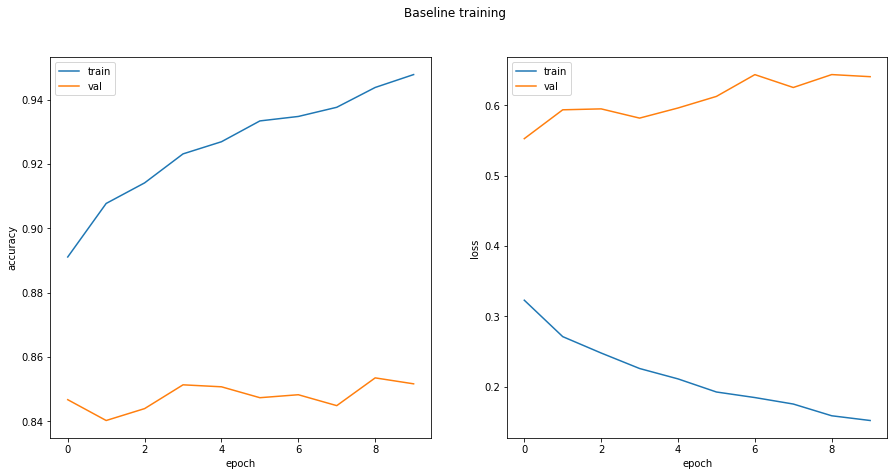

In [112]:
plot_history(history_baseline, 'Baseline training')

In [113]:
torch.save(model_baseline, 'model_baseline.pt')

# Optymalizacja modelu

In [114]:
model_baseline_fused = torch.load('model_baseline.pt')

In [115]:
model_baseline_fused.eval()

Net(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=5184, out_features=10, bias=True)
  )
  (quant): QuantStub()
  (dequant): DeQuantStub()
)

In [116]:
def get_fuse_modules(model):
    modules_list = list(model.model.named_modules())

    fuse_modules = []
    for i in range(len(modules_list)):
        if isinstance(modules_list[i][1], nn.Conv2d):
            if isinstance(modules_list[i + 1][1], nn.ReLU):
                fuse_modules.append(
                    [modules_list[i][0], modules_list[i + 1][0]])

    return fuse_modules

In [117]:
fuse_modules = get_fuse_modules(model_baseline_fused)

quantization.fuse_modules(model_baseline_fused.model,
                          fuse_modules,
                          inplace=True)


Sequential(
  (0): ConvReLU2d(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (1): Identity()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.3, inplace=False)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): ConvReLU2d(
    (0): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (6): Identity()
  (7): Dropout(p=0.3, inplace=False)
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ConvReLU2d(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (10): Identity()
  (11): Dropout(p=0.3, inplace=False)
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=5184, out_features=10, bias=True)
)

In [118]:
model_baseline_fused

Net(
  (model): Sequential(
    (0): ConvReLU2d(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
    )
    (1): Identity()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): ConvReLU2d(
      (0): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
    )
    (6): Identity()
    (7): Dropout(p=0.3, inplace=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvReLU2d(
      (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
    )
    (10): Identity()
    (11): Dropout(p=0.3, inplace=False)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=5184, out_features=10, bias=True)
  )
  (quant): QuantStub()
  (dequant): DeQu

In [119]:
torch.save(model_baseline_fused, 'model_baseline_fused.pt')

In [120]:
model_quant = torch.load('model_baseline_fused.pt')
model_quant.eval()

Net(
  (model): Sequential(
    (0): ConvReLU2d(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
    )
    (1): Identity()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): ConvReLU2d(
      (0): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
    )
    (6): Identity()
    (7): Dropout(p=0.3, inplace=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvReLU2d(
      (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
    )
    (10): Identity()
    (11): Dropout(p=0.3, inplace=False)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=5184, out_features=10, bias=True)
  )
  (quant): QuantStub()
  (dequant): DeQu

In [121]:
torch.backends.quantized.engine = 'qnnpack'
model_quant.qconfig = quantization.get_default_qconfig('qnnpack')
quantization.prepare(model_quant, inplace=True)  # added observers


Net(
  (model): Sequential(
    (0): ConvReLU2d(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (activation_post_process): HistogramObserver()
    )
    (1): Identity()
    (2): BatchNorm2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (activation_post_process): HistogramObserver()
    )
    (3): Dropout(p=0.3, inplace=False)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): ConvReLU2d(
      (0): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (activation_post_process): HistogramObserver()
    )
    (6): Identity()
    (7): Dropout(p=0.3, inplace=False)
    (8): BatchNorm2d(
      128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (activation_post_process): HistogramObserver()
    )
    (9): ConvReLU2d(
      (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (activation_post_process): HistogramObserver()
    )
    (10): Id

In [122]:
num_calibration_batches = 10

model_quant.eval()
for i, (batch, target) in enumerate(train_loader):
    batch, target = batch.to(device), target.to(device)
    model_quant(batch)

    if i + 1 == num_calibration_batches:
        break

In [123]:
model_quant = quantization.convert(model_quant)

In [124]:
torch.save(model_quant, 'model_quant.pt')

In [125]:
model_qat = Net()

fuse_modules = get_fuse_modules(model_qat)
quantization.fuse_modules(model_qat.model, fuse_modules, inplace=True)

model_qat.qconfig = quantization.get_default_qconfig('qnnpack')

In [126]:
quantization.prepare_qat(model_qat,
                         inplace=True)  # performs "fake quantization"


Net(
  (model): Sequential(
    (0): ConvReLU2d(
      1, 32, kernel_size=(3, 3), stride=(1, 1)
      (weight_fake_quant): MinMaxObserver(min_val=inf, max_val=-inf)
      (activation_post_process): HistogramObserver()
    )
    (1): Identity()
    (2): BatchNorm2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (activation_post_process): HistogramObserver()
    )
    (3): Dropout(p=0.3, inplace=False)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): ConvReLU2d(
      32, 128, kernel_size=(3, 3), stride=(1, 1)
      (weight_fake_quant): MinMaxObserver(min_val=inf, max_val=-inf)
      (activation_post_process): HistogramObserver()
    )
    (6): Identity()
    (7): Dropout(p=0.3, inplace=False)
    (8): BatchNorm2d(
      128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (activation_post_process): HistogramObserver()
    )
    (9): ConvReLU2d(
      128, 64, kernel_size=(3, 3), stride=(1, 1)
      (weight_fake_quant):

In [127]:
history_qat = train_model(model_qat, epochs=10)

Epoch   1   Train loss: 1.028683 Acc: 0.667464   Val loss: 0.707750 Acc: 0.777915
Epoch   2   Train loss: 0.674882 Acc: 0.786149   Val loss: 0.619389 Acc: 0.809994
Epoch   3   Train loss: 0.563311 Acc: 0.821007   Val loss: 0.592425 Acc: 0.817705
Epoch   4   Train loss: 0.490148 Acc: 0.842523   Val loss: 0.550575 Acc: 0.834053
Epoch   5   Train loss: 0.425847 Acc: 0.863731   Val loss: 0.549259 Acc: 0.838371
Epoch   6   Train loss: 0.377645 Acc: 0.876456   Val loss: 0.519291 Acc: 0.842690
Epoch   7   Train loss: 0.341198 Acc: 0.889026   Val loss: 0.516363 Acc: 0.851018
Epoch   8   Train loss: 0.303123 Acc: 0.896044   Val loss: 0.525430 Acc: 0.847933
Epoch   9   Train loss: 0.274085 Acc: 0.908691   Val loss: 0.522362 Acc: 0.853486
Epoch  10   Train loss: 0.247462 Acc: 0.913550   Val loss: 0.538037 Acc: 0.846083


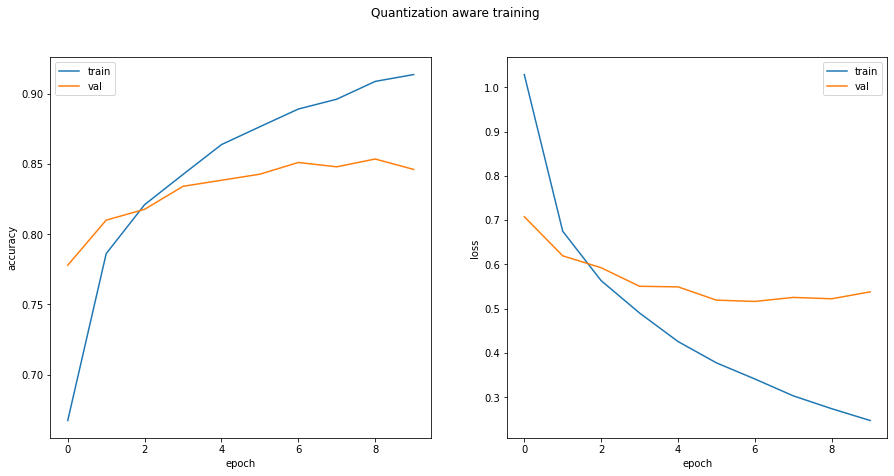

In [128]:
plot_history(history_qat, 'Quantization aware training')

In [129]:
model_qat.eval()
model_qat = torch.quantization.convert(model_qat, inplace=False)

In [130]:
torch.save(model_qat, 'model_qat.pt')

In [131]:
def evaluate_model(model, model_name):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

        acc = correct / len(val_loader.dataset)

    print(model_name, 'test accuracy:', acc)

# Porównanie przed i po - Validation Accuracy

In [135]:
evaluate_model(model_baseline_fused, 'Baseline')
evaluate_model(model_quant, 'Static Quantization')
evaluate_model(model_qat, 'Quantization aware trained model')

Baseline test accuracy: 0.8516347933374461
Static Quantization test accuracy: 0.8488587291795188
Quantization aware trained model test accuracy: 0.8476249228871067


# Porównanie przed i po - Model size

In [136]:
print('pt model files size:\n')
print('Baseline:                   {} bytes'.format(os.path.getsize('model_baseline_fused.pt')))
print('Static quantization:        {} bytes'.format(os.path.getsize('model_quant.pt')))
print('Quantization aware trained: {} bytes'.format(os.path.getsize('model_qat.pt')))

pt model files size:

Baseline:                   666528 bytes
Static quantization:        179464 bytes
Quantization aware trained: 179464 bytes


In [137]:
os.path.getsize('model_baseline_fused.pt') / os.path.getsize('model_quant.pt')

3.7139927784959657

# Summary / extra

In [151]:
model_sparse = torch.load('model_baseline.pt')
model_baseline = torch.load('model_baseline.pt')

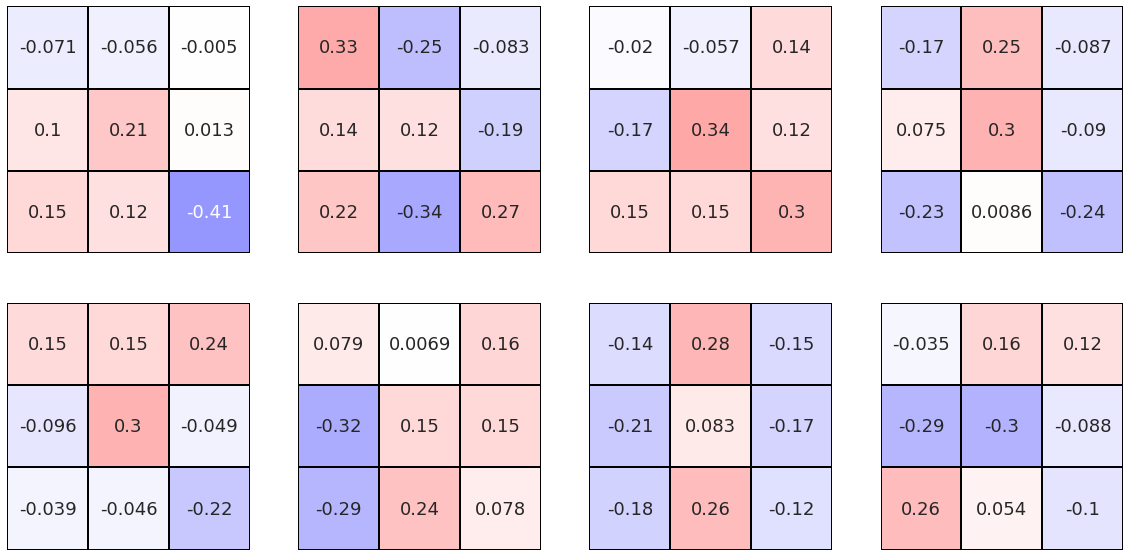

In [147]:
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.5)

w = model_sparse.model[0].weight.cpu()[:, 0, :, :].detach().numpy()

plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(2, 4, 1 + i)
    sns.heatmap(w[i],
                cmap="bwr",
                annot=w[i],
                cbar=False,
                vmin=-1,
                vmax=1,
                linewidths=1,
                linecolor=(0, 0, 0))
    plt.xticks([])
    plt.yticks([])

In [152]:
for layer in model_sparse.model:
    if isinstance(layer, torch.nn.Conv2d):
        prune.l1_unstructured(layer, name='weight', amount=0.8)

    if isinstance(layer, torch.nn.Linear):
        prune.l1_unstructured(layer, name='weight', amount=0.8)

In [155]:
evaluate_model(model_baseline, 'Baseline')
evaluate_model(model_sparse, 'Sparse')

Baseline test accuracy: 0.8516347933374461
Sparse test accuracy: 0.13417643429981493


In [157]:
history_sparse = train_model(model_sparse, 5)

Epoch   1   Train loss: 0.907841 Acc: 0.712809   Val loss: 0.699300 Acc: 0.791487
Epoch   2   Train loss: 0.595167 Acc: 0.803116   Val loss: 0.640627 Acc: 0.809377
Epoch   3   Train loss: 0.501591 Acc: 0.830493   Val loss: 0.610718 Acc: 0.818630
Epoch   4   Train loss: 0.455596 Acc: 0.847922   Val loss: 0.590661 Acc: 0.828192
Epoch   5   Train loss: 0.424528 Acc: 0.855325   Val loss: 0.584758 Acc: 0.829118


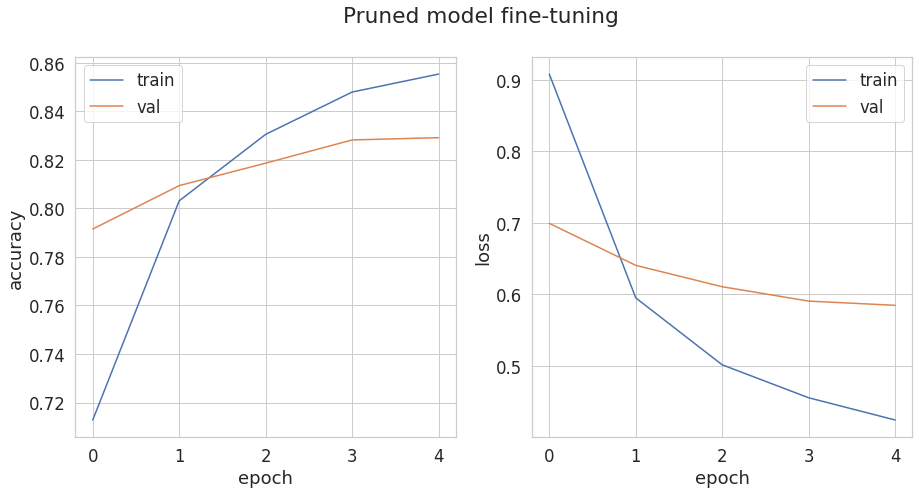

In [158]:
plot_history(history_sparse, 'Pruned model fine-tuning')

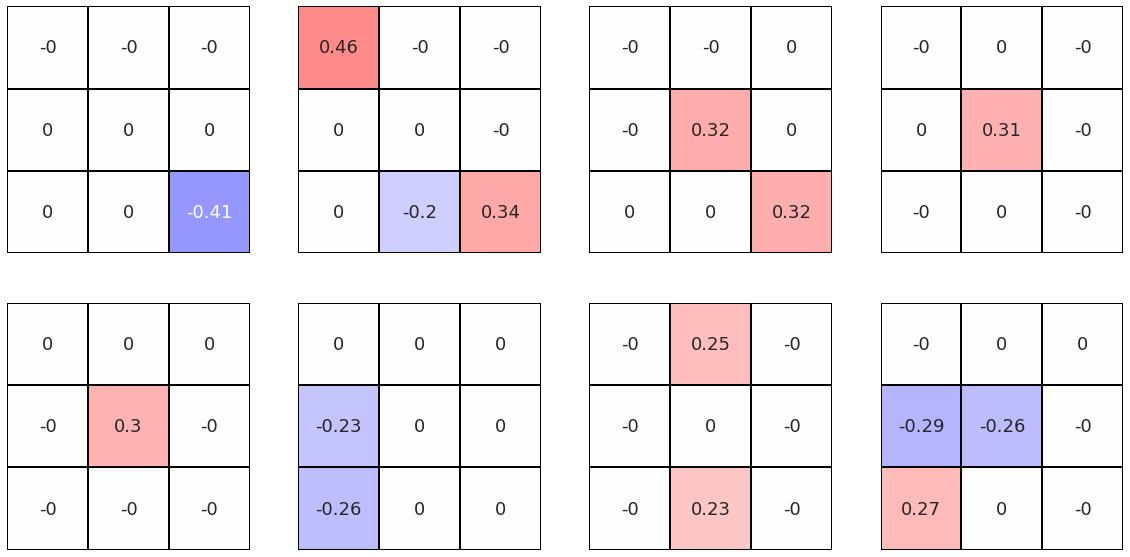

In [159]:
w = model_sparse.model[0].weight.cpu()[:, 0, :, :].detach().numpy()

plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(2, 4, 1 + i)
    sns.heatmap(w[i],
                cmap="bwr",
                annot=w[i],
                cbar=False,
                vmin=-1,
                vmax=1,
                linewidths=1,
                linecolor=(0, 0, 0))
    plt.xticks([])
    plt.yticks([])

In [160]:
for layer in model_sparse.model:
    if isinstance(layer, torch.nn.Conv2d):
        prune.remove(layer, 'weight')

    if isinstance(layer, torch.nn.Linear):
        prune.remove(layer, 'weight')

In [161]:
torch.save(model_sparse, 'model_sparse.pt')

In [162]:
evaluate_model(model_baseline, 'Baseline')
evaluate_model(model_sparse, 'Sparse')

Baseline test accuracy: 0.8516347933374461
Sparse test accuracy: 0.8291178285009253


In [163]:
print('pth model files size:\n')
print('Baseline: {} bytes'.format(os.path.getsize('model_baseline.pt')))
print('Sparse:   {} bytes'.format(os.path.getsize('model_sparse.pt')))

pth model files size:

Baseline: 665568 bytes
Sparse:   665824 bytes


In [167]:
with zipfile.ZipFile('model_baseline_pt.zip', 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write('model_baseline.pt')
    
with zipfile.ZipFile('model_sparse_pt.zip', 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write('model_sparse.pt')

In [168]:
print('Zipped model files size:\n')
print('Baseline: {} bytes'.format(os.path.getsize('model_baseline_pt.zip')))
print('Sparse:   {} bytes'.format(os.path.getsize('model_sparse_pt.zip')))

Zipped model files size:

Baseline: 612331 bytes
Sparse:   202212 bytes


In [169]:
os.path.getsize('model_baseline_pt.zip') / os.path.getsize('model_sparse_pt.zip')

3.028163511562123

In [200]:
import time


def time_inference(model,
                   num_iterations=100,
                   batch_sizes=[512, 1024, 2048, 4096, 8192]):
    model.eval()
    times = []

    for bs in batch_sizes:
        val_loader = torch.utils.data.DataLoader(val_set,
                                                 batch_size=bs,
                                                 shuffle=False)
        tt = []

        for _ in tqdm(range(num_iterations)):
            t = 0

            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)

                    t0 = time.time()
                    output = model(data)
                    t1 = time.time()
                    t += t1 - t0

                    del output
            tt.append(t)
        times.append(tt)

    return np.array(times)

In [178]:
device = 'cuda'

In [201]:
times_baseline = time_inference(model_baseline.to(device))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [202]:
times_sparse = time_inference(model_sparse.to(device))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [203]:
batch_sizes = np.asarray([[bs]*100 for bs in [512, 1024, 2048, 4096, 8192]]).ravel()
batch_sizes = np.append(batch_sizes, batch_sizes)
models = ['baseline']*500 + ['sparse']*500
times = np.concatenate([_ for _ in times_baseline] + [_ for _ in times_sparse])

In [204]:
import pandas as pd
df_times = pd.DataFrame({'batch size': batch_sizes, 'model': models, 'time': times})
df_times

,batch size,model,time
0,512,baseline,0.007754
1,512,baseline,0.006637
2,512,baseline,0.005881
3,512,baseline,0.006922
4,512,baseline,0.006193
...,...,...,...
995,8192,sparse,0.001217
996,8192,sparse,0.001268
997,8192,sparse,0.001258
998,8192,sparse,0.001248


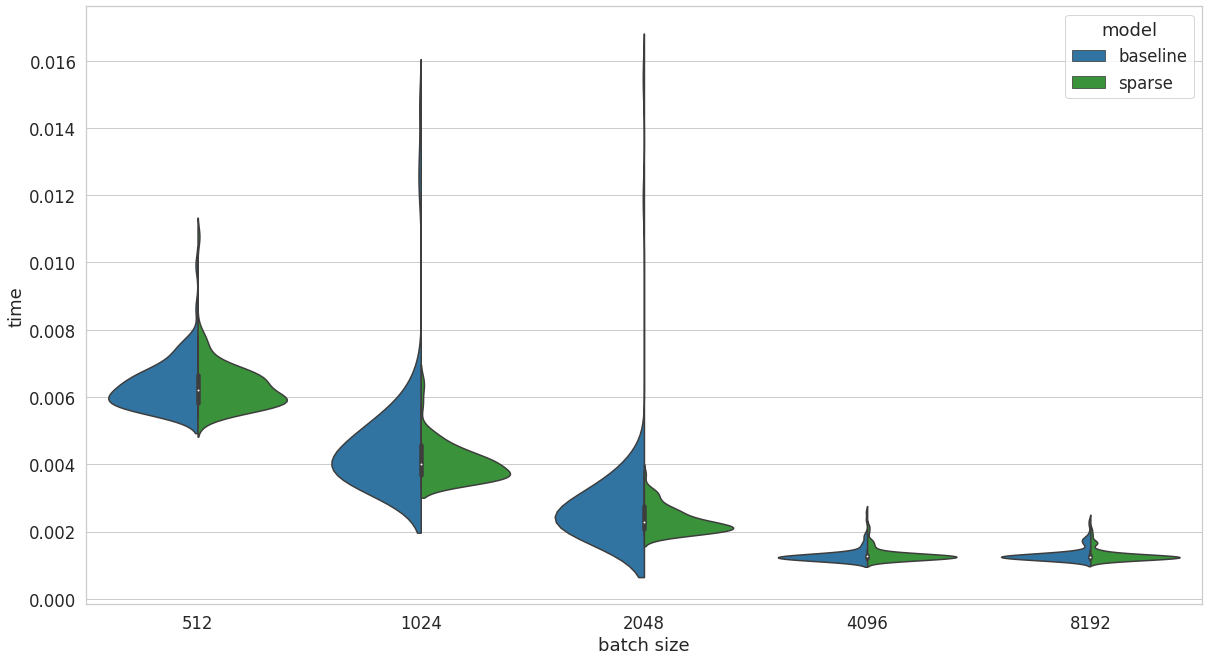

In [205]:
plt.figure(figsize=(20,11))
sns.violinplot(x='batch size', y='time', hue='model', data=df_times, split=True, 
               palette=[sns.color_palette('tab10')[0],sns.color_palette('tab10')[2]], scale='width');

In [232]:
device = 'cuda'
histories = []

for i in range(1, 10, 2):
    model_sparse = torch.load('model_baseline.pt').to(device)
    for layer in model_sparse.model:
        if isinstance(layer, torch.nn.Conv2d):
            prune.l1_unstructured(layer, name='weight', amount=0.1 * i)

        if isinstance(layer, torch.nn.Linear):
            prune.l1_unstructured(layer, name='weight', amount=0.1 * i)
    history_sparse = train_model(model_sparse, 10)
    histories.append(history_sparse)
    for layer in model_sparse.model:
        if isinstance(layer, torch.nn.Conv2d):
            prune.remove(layer, 'weight')

        if isinstance(layer, torch.nn.Linear):
            prune.remove(layer, 'weight')
    evaluate_model(model_sparse, f'Sparse@{10*i}%')


Epoch   1   Train loss: 0.152530 Acc: 0.944166   Val loss: 0.672641 Acc: 0.857187
Epoch   2   Train loss: 0.135979 Acc: 0.951955   Val loss: 0.655773 Acc: 0.848550
Epoch   3   Train loss: 0.126993 Acc: 0.956659   Val loss: 0.685272 Acc: 0.857495
Epoch   4   Train loss: 0.126565 Acc: 0.956428   Val loss: 0.700741 Acc: 0.850093
Epoch   5   Train loss: 0.122326 Acc: 0.957662   Val loss: 0.703955 Acc: 0.852869
Epoch   6   Train loss: 0.108282 Acc: 0.961286   Val loss: 0.690594 Acc: 0.856570
Epoch   7   Train loss: 0.104256 Acc: 0.961132   Val loss: 0.699459 Acc: 0.857804
Epoch   8   Train loss: 0.108075 Acc: 0.962058   Val loss: 0.714508 Acc: 0.852560
Epoch   9   Train loss: 0.100155 Acc: 0.964371   Val loss: 0.715367 Acc: 0.853486
Epoch  10   Train loss: 0.102064 Acc: 0.963214   Val loss: 0.731339 Acc: 0.854102
Sparse@10% test accuracy: 0.8541024059222702
Epoch   1   Train loss: 0.158688 Acc: 0.944783   Val loss: 0.611212 Acc: 0.863048
Epoch   2   Train loss: 0.125579 Acc: 0.953497   Val 

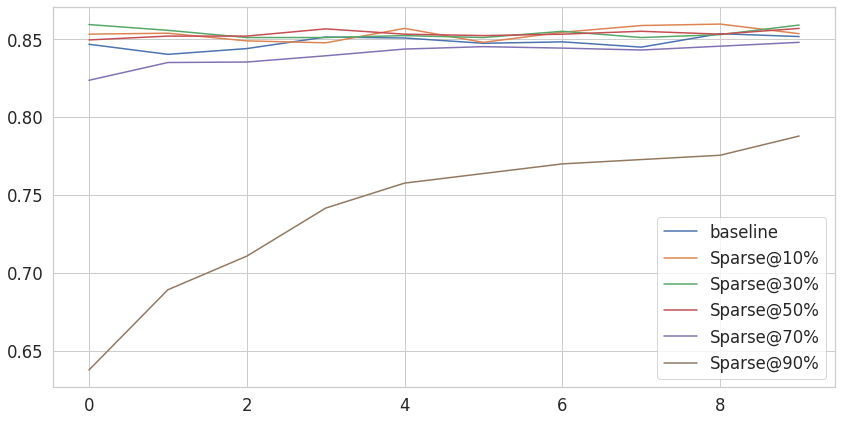

In [230]:
plt.figure(figsize=(14, 7))
plt.plot(history_baseline['val_accuracy'], label='baseline')
for i, history in enumerate(histories):
    plt.plot(history['val_accuracy'], label=f'Sparse@{(i*2+1)*10}%')

plt.legend()

# Wyślij rozwiązanie
Możesz skorzystać z jednego z poniższych sposobów:
**mailem na specjalny adres** ze strony pracy domowej w panelu programu prześlij jedno z poniższych:
- notebooka (jeżeli plik ma mniej niż np. 10MB)
- notebooka w zipie
- link do Colaba (udostępniony)
- link do pliku przez GDrive/Dropboxa/WeTransfer/...
- pdfa (poprzez download as pdf)
- jako plik w repozytorium na np. GitHubie, by budować swoje portfolio (wtedy uważaj na wielkość pliku, najlepiej kilka MB, Max 25MB)

Najlepiej, by w notebooku było widać wyniki uruchomienia komórek, chyba, że przez nie plik będzie mieć 100+MB wtedy najlepiej Colab lub jakieś przemyślenie co poszło nie tak (zbyt dużo dużych zdjęć wyświetlonych w komórkach).

## Co otrzymasz?
Informację zwrotną z ewentualnymi sugestiami, komentarzami.